In [1]:
import sys
import os
import numpy as np
import pyccl as ccl
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc'
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)


import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.integrate import quad,simps, dblquad
from scipy.optimize import curve_fit

In [2]:
import numpy as np
from scipy.integrate import quad, simps
import cluster_toolkit as ct
from cluster_toolkit import deltasigma

In [3]:
clmm.__version__

'0.9.2'

In [ ]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling')
import Einasto_profile as ein
import NFW_profile as nfw
import Hernquist_profile as hern

In [69]:
cluster_m = 5e14
cluster_z = 0.5
concentration = 3
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
cosmo_ccl = ccl.Cosmology(Omega_c=0.27-0.045, Omega_b=0.045, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)
moo_ein = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
moo_ein.set_cosmo(mock_cosmo)
moo_ein.set_mass(cluster_m) 
moo_ein.set_concentration(concentration)

In [70]:
rho_c = cosmo_astropy.critical_density(cluster_z).to(u.M_sun/u.Mpc**3) 

### Compute Miscentering

In [71]:
R = np.logspace(-4,1, 2000)
r3d_test = np.logspace(-2, 2,1000)
rho_test = moo.eval_3d_density(r3d_test, cluster_z)

In [72]:
def s(R, rd):
    snfw = []
    def integrand(x, y):
        u = np.sqrt(y**2 + x**2)
        return np.interp(u,r3d_test, rho_test)
    for r in R:
        
        if r < rd: lim = np.sqrt(rd**2 - r**2)
        else: lim = 0
        snfw.append(quad(integrand, -lim, +lim, args=(r))[0])
    
    return np.array(snfw)

In [73]:
r200c = ((3/(np.pi*4))*cluster_m*(1./(200*rho_c)))**(1/3)
r200c_v =r200c.value
rd_ = list(r200c_v + np.linspace(0.,7,4))
rd_ = np.sort(rd_)

In [74]:
profile = {'surface_density' : [], 'r_cut': [], 'radius': [], 'excess_surface_density': []}

In [75]:
for i,rd in enumerate(rd_): 
    print(rd)
    
    profile['surface_density'].append(s(R, rd))
    profile['radius'].append(R)
    profile['r_cut'].append(rd)

1.3782598842638638


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


3.7115932175971973
6.044926550930531
8.378259884263864


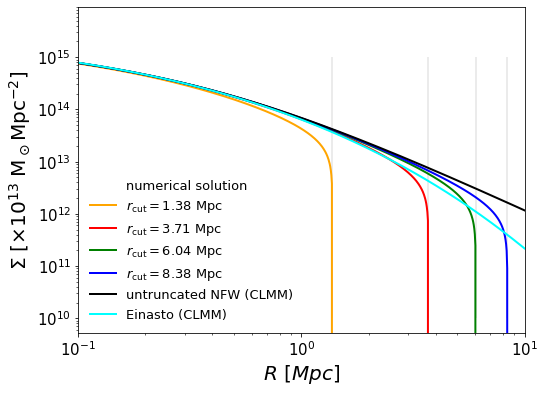

In [91]:
plt.figure(figsize = (8,6))
plt.plot([],[],'w', label = 'numerical solution')
c = ['orange', 'r','g','b']
for i,rd in enumerate(rd_): 
    
    r_cut = profile['r_cut'][i]
    
    plt.loglog(profile['radius'][i],profile['surface_density'][i], '-', label = r'$r_{\rm cut} =$' + f'{r_cut:.2f} Mpc', color = c[i], linewidth = 2)
    plt.vlines(profile['r_cut'][i], 1e10, 1e15, alpha = 0.1)
plt.plot(R, moo.eval_surface_density(R, cluster_z), '-k', label = f'untruncated NFW (CLMM)', linewidth = 2)
plt.plot(R, moo_ein.eval_surface_density(R, cluster_z), 'cyan', label = f'Einasto (CLMM)', linewidth = 2)
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$\Sigma$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 13, frameon = False)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlim(1e-1,max(R))
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/sigma_trunc.png', dpi = 300)

In [77]:
R_perp = np.logspace(-1,1,100)

In [78]:
profile['excess_surface_density'] = []
for i,r_cut in enumerate(rd_): 
    print(r_cut)
    
    ds = []
    
    for j, Rr in enumerate(R_perp):
        
        def integrand(x,y):
            
            if x < profile['r_cut'][i]:
                return  (2/y**2)*x*np.interp(x, profile['radius'][i], profile['surface_density'][i])
            else: return 0#return (2/y**2)*x*np.interp(profile['r_cut'][i], profile['radius'][i], profile['surface_density'][i])
            
        if Rr < profile['r_cut'][i]: s = np.interp(Rr, profile['radius'][i], profile['surface_density'][i])
        
        else: s = 0
        
        ds.append(quad(integrand, 0, Rr, args=(Rr))[0] - s)
        
    ds = np.array(ds)
    
    profile['excess_surface_density'].append(ds)

1.3782598842638638


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


3.7115932175971973
6.044926550930531
8.378259884263864


In [79]:
cl_200c = nfw.Modeling(cluster_m, concentration, cluster_z, 'critical', cosmo_astropy)

In [80]:
def ds_trunc(R, R_cut):
    ds = []
    for r in R:
        if r < R_cut : ds.append(moo.eval_excess_surface_density(r, cluster_z))
        else: ds.append(cl_200c.M(R_cut)/(np.pi*r**2))
    return np.array(ds)

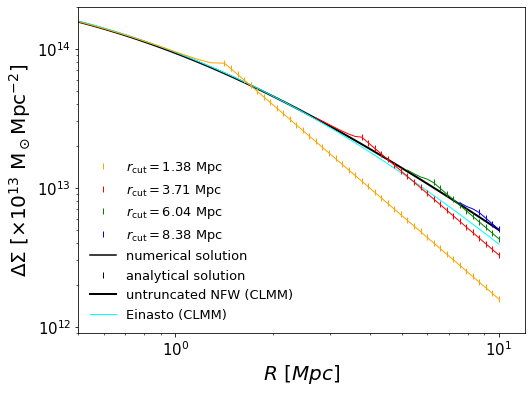

In [99]:
c = ['orange', 'r','g','b']
plt.figure(figsize = (8,6))
for i,r_cut in enumerate(rd_): 
    r_cut = profile['r_cut'][i]
    plt.loglog(R_perp[R_perp > r_cut-1],profile['excess_surface_density'][i][R_perp > r_cut-1], '-',  linewidth = 1, color = c[i])
    plt.loglog(R_perp[R_perp > r_cut], ds_trunc(R_perp[R_perp > r_cut], r_cut), '|', color = c[i],label = r'$r_{\rm cut} =$' + f'{r_cut:.2f} Mpc',)
plt.xscale('log')
plt.loglog(R_perp[R_perp > r_cut], 0*R_perp[R_perp > r_cut], '-', color = 'k',label = r'numerical solution')
plt.loglog(R_perp[R_perp > r_cut], 0*R_perp[R_perp > r_cut], '|', color = 'k',label = r'analytical solution')
plt.plot(R_perp, moo.eval_excess_surface_density(R_perp, cluster_z), '-k', label = f'untruncated NFW (CLMM)', linewidth = 2, zorder = 0)
plt.plot(R_perp, moo_ein.eval_excess_surface_density(R_perp, cluster_z), 'cyan', label = f'Einasto (CLMM)', linewidth = 1, zorder = 1)
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 13, frameon = False)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.ylim(9e11,2e14)
plt.xlim(0.5,12)
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/pro_s.png', dpi = 300)